In [28]:
# -*- coding: utf-8 -*-
"""
Created on Thu Dec 19 17:08:19 2024

@author: Rodrigo Meira
"""
from libs.eos_database import *
from libs.compressor_class import *
from libs.compression import *
from libs.gc_eos_soave import *
from libs.viscosity import *
from libs.plenum_system import *
from libs.simulation import *
from libs.model import *

from casadi import *
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import torch
from scipy.stats import qmc
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import time

In [29]:
list_names = ["CH4", "C2H6", "C3H8", "iC4H10", "nC4H10", "iC5H12", "nC5H12", 
                  "nC6H14", "nC7H16", "nC8H18", "nC9H20", "nC10H22", "nC11H24", 
                   "nC12H26", "nC14H30", "N2", "H2O", "CO2", "C15+"]

nwe = [0.9834, 0.0061, 0.0015, 0.0003, 0.0003, 0.00055, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0, 0.0008, 0.0]

dict_composition= {list_names[i]: nwe[i] for i in range(len(nwe))}

mixture = Mixture(list_of_species, dict_composition)

volumn_desviation = [0] * 19

vlv = valve(kv=0.38)
Vpp = 2.0 
Lc = 2.0 
A1 = 2.6e-3
gas = gc_eos_class(mixture, 300, 4500, None, 1, 0, Aij, volumn_desviation, 'gas')
comp = CompressorClass()
visc = viscosity(mixture, volumn_desviation)
compressor = compression(gas, comp, visc)
plenum_sys = plenum(gas, compressor, vlv, Vpp, Lc, A1)

In [30]:
nAlphas = 300

sampler_N_RotS = qmc.LatinHypercube(d=1)  # d=1 porque estamos amostrando uma única variável
samples_N_RotS = sampler_N_RotS.random(n=nAlphas+1)
N_RotS = qmc.scale(samples_N_RotS, 600, 750).flatten()  # Redimensiona para 1D
sampler_alphas = qmc.LatinHypercube(d=1)
samples_alphas = sampler_alphas.random(n=nAlphas+1)
alphas = qmc.scale(samples_alphas, 0.36, 0.65).flatten()

nData = 160
dt = 0.5
timestep = 3
x0 = [14.9919, 339.69, 0.42885]
z0 = [6245.39, 6245.39, 321.672, 0.445562, 319.423, 0.503621, 320.097, 0.396345, 339.69, 0.42885, 0.514917]
u0 = [4500, 300, 600, alphas[0], 5000]

In [4]:
# sim = Simulation(plenum_sys, compressor, x0, z0, u0, nAlphas, alphas, N_RotS, nData, dt, timestep)
# x_values, z_values, time_steps, alpha_values, N_values, x_train, y_train, x_min, x_max, y_min,y_max = sim.run()

# sim_data = {
#     "x_values": x_values,
#     "z_values": z_values,
#     "time_steps": time_steps,
#     "x_train": x_train,
#     "y_train": y_train,
#     "x_min": x_min,
#     "x_max": x_max,
#     "y_min": y_min,
#     "y_max": y_max

# }

# np.savez(
#     "simulation_data.npz",
#     x_values=x_values,
#     z_values=z_values,
#     time_steps=time_steps,
#     alpha_values=alpha_values,
#     N_values=N_values,
#     x_train=x_train,
#     y_train=y_train,
#     x_min=x_min,
#     x_max=x_max,
#     y_min = y_min,
#     y_max = y_max

# )


In [31]:
data = np.load("simulation_data.npz")

x_values = data["x_values"]
z_values = data["z_values"]
time_steps = data["time_steps"]
alpha_values = data["alpha_values"]
N_values = data["N_values"]
x_train = data["x_train"]
y_train = data["y_train"]
x_min = data["x_min"]
x_max = data["x_max"]
y_min = data["y_min"]
y_max = data["y_max"]


x_min = torch.tensor(x_min, dtype = torch.float32)
x_max = torch.tensor(x_max, dtype = torch.float32)
y_min = torch.tensor(y_min, dtype = torch.float32)
y_max = torch.tensor(y_max, dtype = torch.float32)
x_train = torch.tensor(np.array(x_train), dtype=torch.float32)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32)
x_train_split, X_val, y_train_split, y_val = train_test_split(
    x_train, 
    y_train, 
    test_size=0.3,  
    random_state=42,  
    shuffle=True      
)
y_train_split = y_train_split.squeeze()
y_val = y_val.squeeze()
train_dataset = torch.utils.data.TensorDataset(x_train_split, y_train_split)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 64, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size= 64, shuffle=False)

In [6]:
model = MyModel(150, dt, x_max, x_min, y_min, y_max, plenum_sys)# Criar a instância do modelo novamente

In [7]:
# modelo = MyModel(200, dt, x_max, x_min, y_min, y_max, plenum_sys)  # mesma definição usada antes
# modelo.load_state_dict(torch.load('pesos_modelo.pth'))


In [8]:
train_loss_values = model.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr= 1e-4,
    epochs=30,
    optimizers=torch.optim.Adam,
    patience=2,
    factor=0.5,
    gas = gas
)

Batch 0 completed in 6.10s | Data: 185292.8438 | Phys: 2871.8955
Batch 1 completed in 3.24s | Data: 166551.7812 | Phys: 3034.3296
Batch 2 completed in 3.16s | Data: 238625.0781 | Phys: 2576.5405
Batch 3 completed in 3.30s | Data: 186841.7500 | Phys: 3099.9678
Batch 4 completed in 3.21s | Data: 202965.6250 | Phys: 2663.2415
Batch 5 completed in 3.57s | Data: 186371.2969 | Phys: 2637.3745
Batch 6 completed in 3.46s | Data: 226075.0625 | Phys: 2663.0112
Batch 7 completed in 3.31s | Data: 194589.3594 | Phys: 3015.8999
Batch 8 completed in 2.19s | Data: 209619.9062 | Phys: 3148.6956
Batch 9 completed in 3.21s | Data: 196385.6875 | Phys: 2911.8564
Batch 10 completed in 3.29s | Data: 231044.2656 | Phys: 2792.4736
Batch 11 completed in 3.19s | Data: 165809.3906 | Phys: 2586.0146
Batch 12 completed in 3.22s | Data: 213901.0781 | Phys: 2710.1155
Batch 13 completed in 3.26s | Data: 203242.9062 | Phys: 2565.3784
Batch 14 completed in 3.18s | Data: 195565.2500 | Phys: 2320.7585
Batch 15 completed i

/home/matheus/Trabalho/UFBA/New_project/libs/model.py:51: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  sol = fsolve(self.system_residuals, z0, args=(x0, u0, plenum_sys))


Batch 306 completed in 2.89s | Data: 114.1952 | Phys: 3.9146
Batch 307 completed in 2.86s | Data: 38.8339 | Phys: 2.9874
Batch 308 completed in 2.79s | Data: 34.8344 | Phys: 3.3476
Batch 309 completed in 2.79s | Data: 1096.1196 | Phys: 4.5884
Batch 310 completed in 2.82s | Data: 62.2674 | Phys: 2.9470
Batch 311 completed in 2.79s | Data: 18.7788 | Phys: 1.0317
Batch 312 completed in 2.81s | Data: 1358.2100 | Phys: 3.4824
Batch 313 completed in 2.79s | Data: 3329.5908 | Phys: 3.3703
Batch 314 completed in 2.81s | Data: 71.2494 | Phys: 7.4936
Batch 315 completed in 2.83s | Data: 84.8986 | Phys: 1.9083
Batch 316 completed in 2.77s | Data: 138.7175 | Phys: 9.3947
Batch 317 completed in 2.78s | Data: 153.7022 | Phys: 1.2014
Batch 318 completed in 0.20s | Data: 29.4989 | Phys: 1.5528
Batch 319 completed in 2.78s | Data: 28.0824 | Phys: 3.5130
Batch 320 completed in 2.74s | Data: 24.3903 | Phys: 1.4817
Batch 321 completed in 2.83s | Data: 22.9690 | Phys: 2.3776
Batch 322 completed in 2.78s | 

In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [50]:
nAlphas_teste = 7

sampler_N_RotS_teste = qmc.LatinHypercube(d=1)  # d=1 porque estamos amostrando uma única variável
samples_N_RotS_teste = sampler_N_RotS_teste.random(n=nAlphas_teste+1)
N_RotS_teste = qmc.scale(samples_N_RotS_teste, 600, 750).flatten()  # Redimensiona para 1D
sampler_alphas_teste = qmc.LatinHypercube(d=1)
samples_alphas_teste = sampler_alphas_teste.random(n=nAlphas_teste+1)
alphas_teste = qmc.scale(samples_alphas_teste, 0.35, 0.65).flatten()  

sim2 = sim = Simulation(plenum_sys, compressor, x0, z0, u0, nAlphas_teste, alphas_teste, N_RotS_teste, 160, dt, timestep)
x_values_teste, z_values_teste, time_steps, alpha_values_teste, N_values_teste, x_teste, y_teste, x_min, x_max, y_min, y_max = sim.run()
interval3 = np.linspace(0, 160*nAlphas_teste, len(x_teste))

In [33]:
import torch

# Rodar a inferência corretamente
model.eval()  # Importante colocar a rede em modo de avaliação
with torch.no_grad():
    y_pred = model(x_teste)

# Checar se y_pred realmente varia
for name, param in model.named_parameters():
    print(f"{name}: mean={param.mean().item()}, std={param.std().item()}")



lstm.weight_ih_l0: mean=0.002660108730196953, std=0.08085302263498306
lstm.weight_hh_l0: mean=0.0002464444551151246, std=0.07874562591314316
lstm.bias_ih_l0: mean=0.03361964225769043, std=0.06983616203069687
lstm.bias_hh_l0: mean=0.02742038294672966, std=0.06966804713010788
output_layer.weight: mean=-0.003977049607783556, std=0.11773228645324707
output_layer.bias: mean=-0.001046933000907302, std=0.07577594369649887


In [ ]:
# torch.onnx.export(
#     model,
#     x_teste,
#     "modelo_simples15.onnx",
#     export_params=True,
#     opset_version=17,
#     input_names=["input"],
#     output_names=["output"],
#     dynamic_axes={
#         "input": {0: "batch_size"},  # Permite batch variável
#         "output": {0: "batch_size"},
#     },
# )

/home/matheus/.local/lib/python3.12/site-packages/torch/onnx/symbolic_opset9.py:4277: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [35]:
import onnxruntime as ort
import numpy as np

# Converter o tensor para NumPy e ajustar o dtype
x_teste_np = x_teste.detach().cpu().numpy().astype(np.float32)  # Garanta float32

# Se o modelo esperar um batch dimension (ex: [batch, seq_len, features]), adicione:
if x_teste_np.ndim == 1:
    x_teste_np = x_teste_np[np.newaxis, ...]  # Adiciona dimensão de batch (batch=1)

# Carregar o modelo ONNX
ort_session = ort.InferenceSession("modelo_simples13.onnx")

# Executar inferência corretamente
input_name = ort_session.get_inputs()[0].name
outputs = ort_session.run(None, {input_name: x_teste_np})[0]

In [ ]:
import matplotlib.pyplot as plt

# Remover dimensões extras de y_pred e y_teste (se houver)
outputs = outputs.squeeze()
y_teste = y_teste.squeeze()

# Número de variáveis de saída
num_outputs = y_teste.shape[1]

# Ajustar o tamanho da lista time_steps para corresponder aos dados de teste
time_steps = time_steps[:y_teste.shape[0]]
 
# Criar os gráficos separadamente para cada saída
for i in range(num_outputs):
    plt.figure(figsize=(8, 4))  # Criar uma nova figura para cada gráfico
    plt.plot(time_steps, y_teste[:, i], label="Saída Esperada (y_teste)", color="red", linestyle="--")
    plt.plot(time_steps, outputs[:, i], label="Saída da Rede (outputs)", color="blue", linestyle="-")
    
    plt.xlabel("Time Step")
    plt.ylabel("Valor")
    plt.title(f"Saída {i}")  # Título do gráfico indicando o índice da saída
    plt.legend()
    plt.grid(True)
    
    plt.show()  # Mostrar o gráfico

"[0, 1, 2, 3, 5, 7, 9, 11]"

In [ ]:
print(x_teste.shape)

In [51]:
onnx_model_path = "./modelo_simples13.onnx"
onnx_session = ort.InferenceSession(onnx_model_path)


# Iniciar listas com os 3 primeiros passos
massFlowrate_pred = [x_teste[0, 0, 0].item(), x_teste[0, 1, 0].item(), x_teste[0, 2, 0].item()]
Temperatura_pred = [x_teste[0, 0, 1].item(), x_teste[0, 1, 1].item(), x_teste[0, 2, 1].item()]
PlenumPressure_pred = [x_teste[0, 0, 2].item(), x_teste[0, 1, 2].item(), x_teste[0, 2, 2].item()]
Pressure2_pred = [x_teste[0, 0, 3].item(), x_teste[0, 1, 3].item(), x_teste[0, 2, 3].item()]
Temperatura2_pred = [x_teste[0, 0, 4].item(), x_teste[0, 1, 4].item(), x_teste[0, 2, 4].item()]

input_tensor = torch.zeros((1, 3, 7), dtype=torch.float32)

# Lista para armazenar TODAS as predições (com 14 variáveis por passo)
all_predictions = []

tm1 = time.time()

for i in range(len(interval3)):
    # Atualiza as entradas com as 3 últimas predições
    input_tensor[0, :, 0] = torch.tensor(massFlowrate_pred[-3:])
    input_tensor[0, :, 1] = torch.tensor(Temperatura_pred[-3:])
    input_tensor[0, :, 2] = torch.tensor(PlenumPressure_pred[-3:])
    input_tensor[0, :, 3] = torch.tensor(Pressure2_pred[-3:])
    input_tensor[0, :, 4] = torch.tensor(Temperatura2_pred[-3:])
    input_tensor[0, :, 5] = x_teste[i, :, 5]
    input_tensor[0, :, 6] = x_teste[i, :, 6]

    # Previsão com ONNX
    onnx_inputs = {'input': input_tensor.numpy()}
    onnx_outputs = onnx_session.run(None, onnx_inputs)
    output_step = onnx_outputs[0][0]  # vetor de 14 saídas

    # Armazena toda a predição
    all_predictions.append(output_step)

    # Atualiza as listas para retroalimentação (opcional)
    massFlowrate_pred.append(output_step[0])
    Temperatura_pred.append(output_step[1])
    PlenumPressure_pred.append(output_step[3])
    Pressure2_pred.append(output_step[4])
    Temperatura2_pred.append(output_step[11])

tm2 = time.time()
timeteste = tm2 - tm1

print(f"Tempo de teste: {timeteste:.4f}s")

# Converter para array numpy
all_predictions = np.array(all_predictions)  # shape (N, 14)
y_true = y_teste
  # pula os 3 primeiros passos do warm-up

# Avaliar R² e RMSE
r2_list = []
rmse_list = []
print(y_teste.shape)
print(all_predictions.shape)
for i in range(14):
    r2 = r2_score(y_true[:, i], all_predictions[:, i])
    rmse = np.sqrt(mean_squared_error(y_true[:, i], all_predictions[:, i]))
    r2_list.append(r2)
    rmse_list.append(rmse)

# Exibir resultados
print("\nMétricas por variável:")
for i in range(14):  # Para todas as variáveis de 0 a 13
    print(f"Variável {i} | R² = {r2_list[i]:.4f} | RMSE = {rmse_list[i]:.6f}")

Tempo de teste: 0.1046s
torch.Size([1117, 14])
(1117, 14)

Métricas por variável:
Variável 0 | R² = 0.9653 | RMSE = 0.211053
Variável 1 | R² = 0.9798 | RMSE = 1.083435
Variável 2 | R² = 0.9947 | RMSE = 0.002232
Variável 3 | R² = 0.9964 | RMSE = 60.750440
Variável 4 | R² = 0.9828 | RMSE = 131.031895
Variável 5 | R² = 0.9826 | RMSE = 0.336253
Variável 6 | R² = 0.9848 | RMSE = 0.001425
Variável 7 | R² = 0.9835 | RMSE = 0.332440
Variável 8 | R² = 0.9866 | RMSE = 0.001672
Variável 9 | R² = 0.9858 | RMSE = 0.847060
Variável 10 | R² = 0.9861 | RMSE = 0.003483
Variável 11 | R² = 0.9822 | RMSE = 0.902790
Variável 12 | R² = 0.9858 | RMSE = 0.003706
Variável 13 | R² = 1.0000 | RMSE = 0.000000


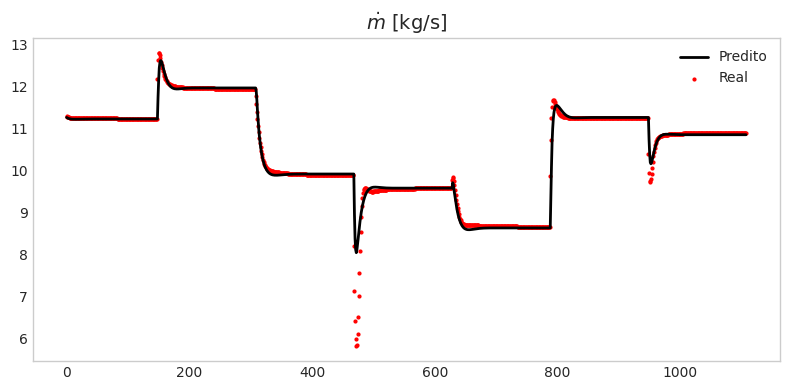

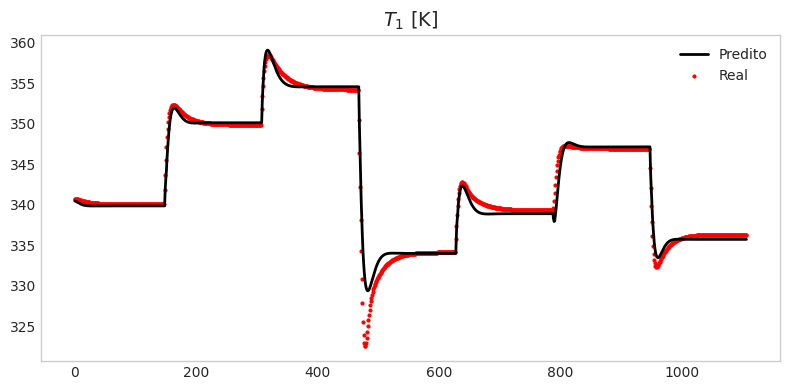

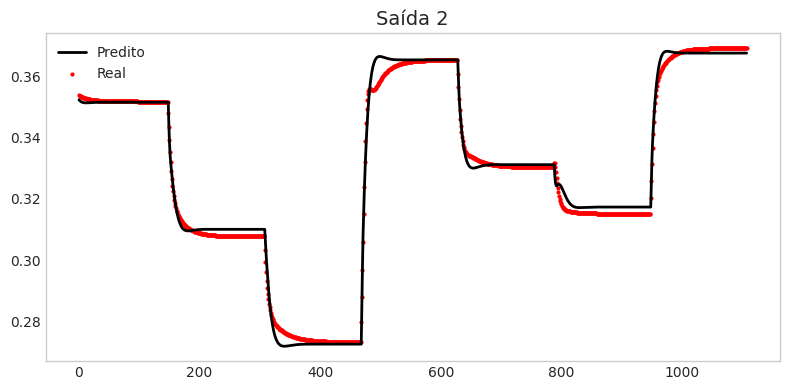

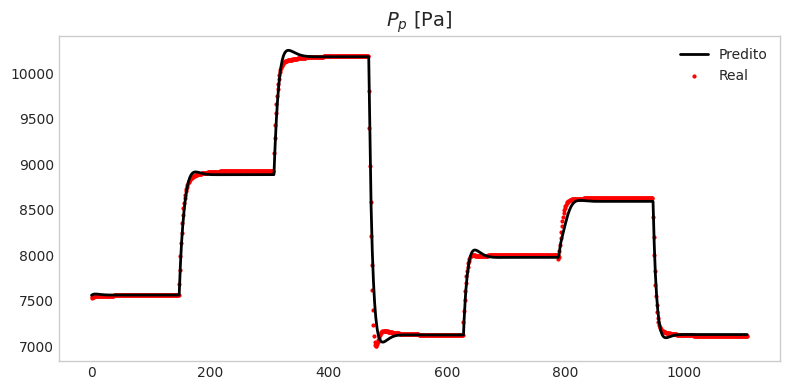

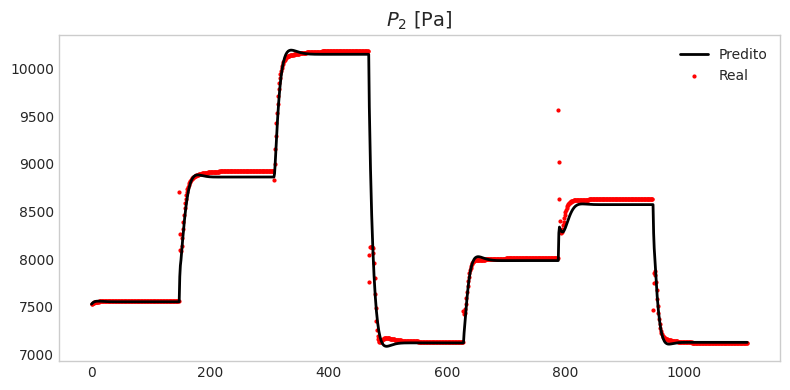

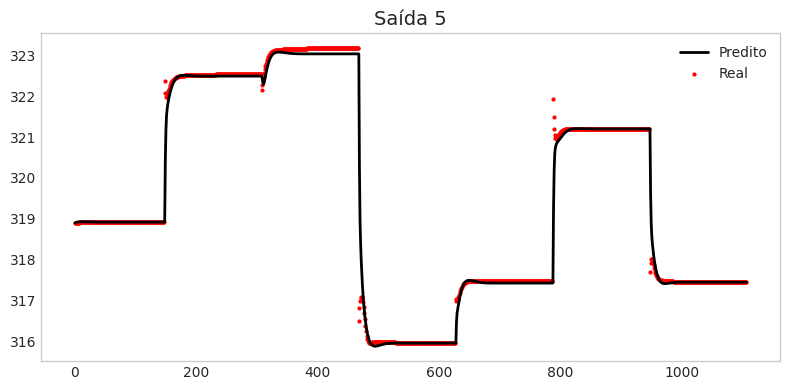

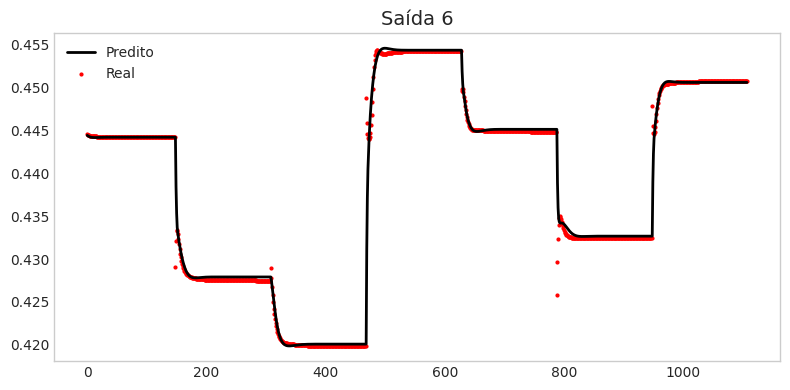

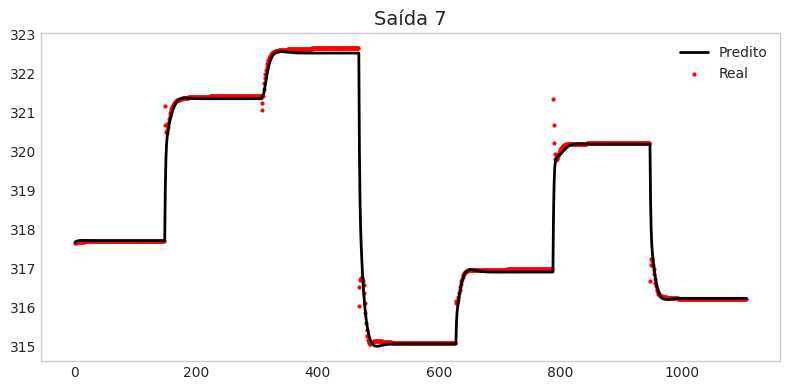

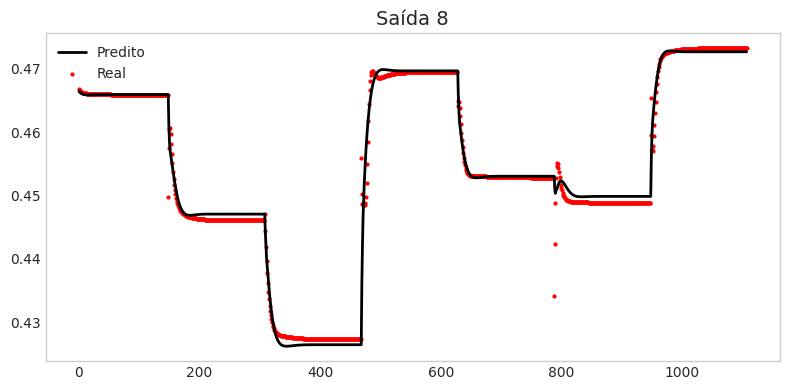

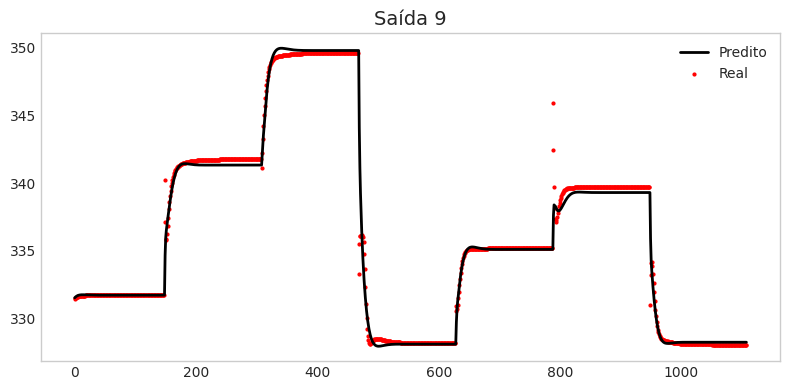

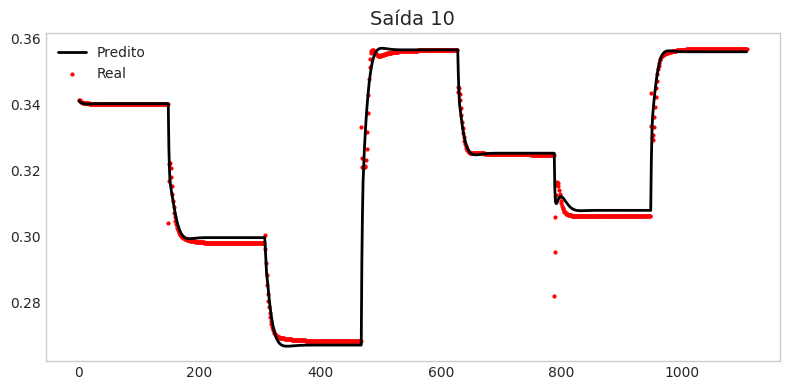

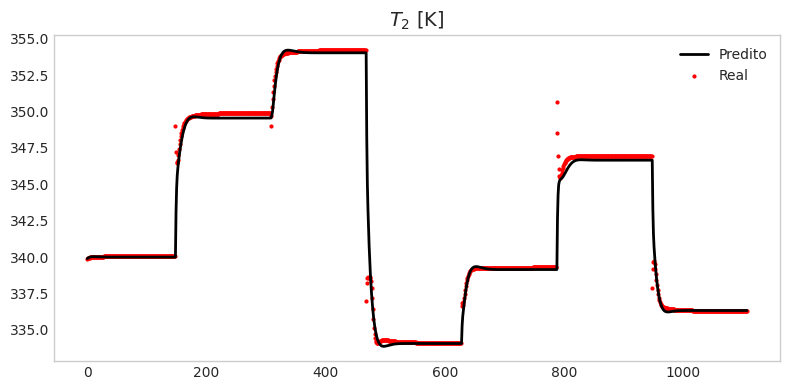

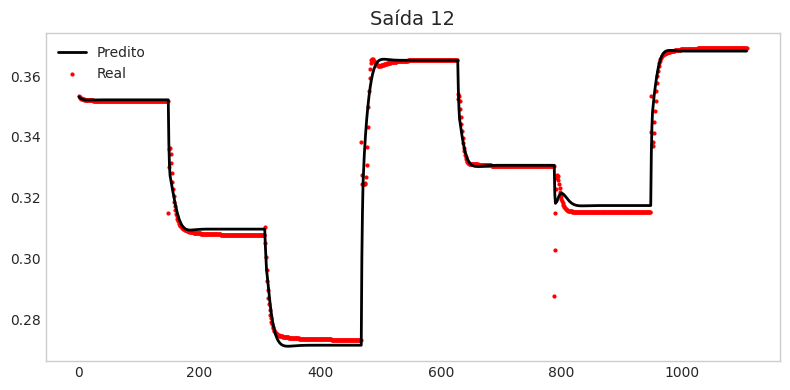

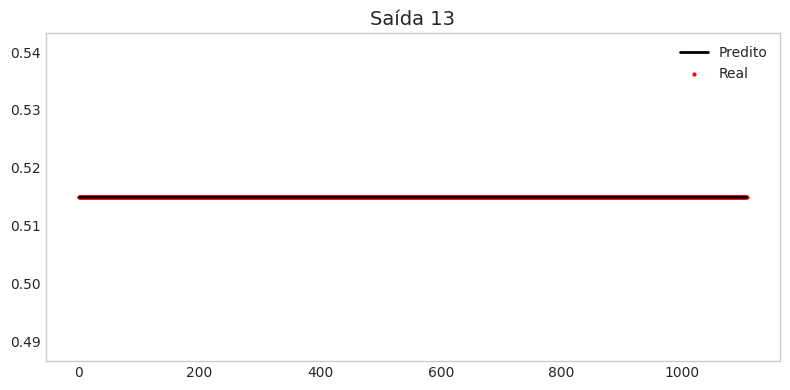

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Converter listas para numpy arrays (removendo os 3 primeiros)
massFlowrate_pred = np.array(massFlowrate_pred[3:])
Temperatura_pred = np.array(Temperatura_pred[3:])
PlenumPressure_pred = np.array(PlenumPressure_pred[3:])
Pressure2_pred = np.array(Pressure2_pred[3:])
Temperatura2_pred = np.array(Temperatura2_pred[3:])
all_predictions = np.array(all_predictions)[3:]  # se necessário
y_teste = np.array(y_teste)[3:]

labels = [
    r'$\dot{m}$ [kg/s]', r'$T_1$ [K]', r'Saída 2', r'$P_p$ [Pa]', r'$P_2$ [Pa]', r'Saída 5',
    r'Saída 6', r'Saída 7', r'Saída 8', r'Saída 9', r'Saída 10', r'$T_2$ [K]',
    r'Saída 12', r'Saída 13'
]

# Mostrar um gráfico por vez
for i in range(14):
    plt.figure(figsize=(8, 4))
    plt.plot(all_predictions[:, i], label='Predito', color='black', linewidth=2)
    plt.scatter(np.arange(len(y_teste[:, i])), y_teste[:, i], label='Real', color='red', s=4)
    plt.title(labels[i], fontsize=14)
    plt.legend(fontsize=10)
    plt.tick_params(axis='both', labelsize=10)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

